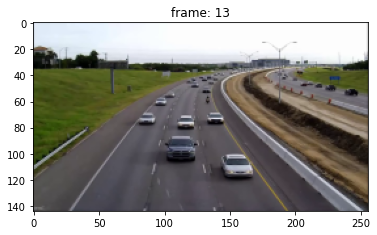

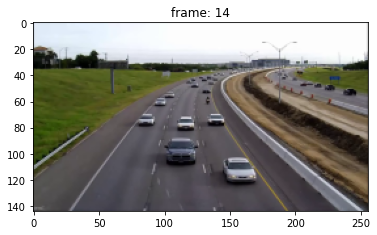

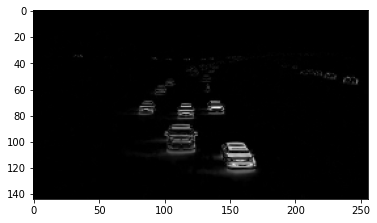

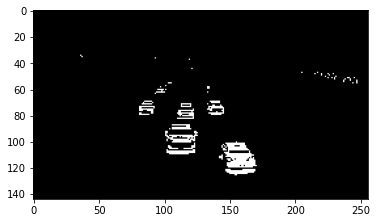

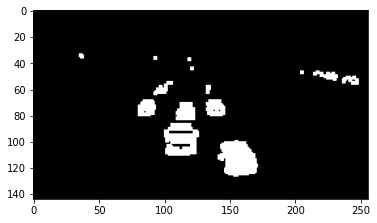

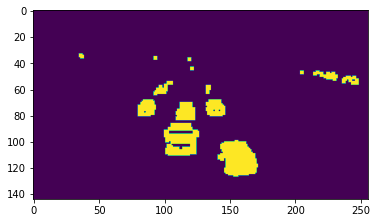

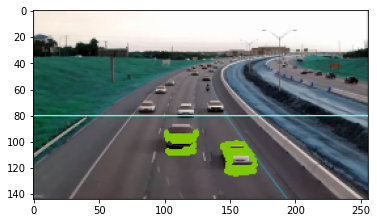

In [2]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

# get file names of the frames
col_frames = os.listdir('frames/')

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread('frames/'+i)
    # append the frames to the list
    col_images.append(img)


# plot 13th frame
i = 13

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# plot image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

# apply image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# plot dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

# plot vehicle detection zone
plt.imshow(dilated)
cv2.line(dilated, (0, 80),(256,80),(100, 0, 0))
plt.show()

# find contours
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

dmy = col_images[13].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
plt.imshow(dmy)
plt.show()


# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "contour_frames_3/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy)  
	
# specify video name
pathOut = 'vehicle_detection_v3.mp4'

# specify frames per second
fps = 14.0

frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()